In [1]:
#|default_exp app_v1

## Reimplementing DiffEdit

In this notebook we're going to reimplement the semantic image editing process illustrated in the [DiffEdit](https://arxiv.org/abs/2210.11427) paper. In the paper, the authors proposed using text input to create a mask of the queried object, and essentially using an img2img type of processing, such that changes could be made to the object without making changes to the context of the image. 

## Example

<center><img alt="DiffEdit Workflow" width="1000" src="imgs/diffusion_method2.jpg" /></center>

### Imports

In [2]:
#| export
import torch
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import PIL
from IPython.display import display
import tsensor
from lolviz import *

import matplotlib as mpl
import logging

plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["figure.dpi"] = 288

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
logging.disable(logging.WARNING)
torch.manual_seed(1);

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

### CLIP Tokenizer and Text Encoder

In [4]:
#| export
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

### VAE and UNET

In [5]:
#| export
from diffusers import AutoencoderKL, UNet2DConditionModel

In [6]:
#| export
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

### Import Image

In [7]:
#| export
im = PIL.Image.open('imgs/IMG_4104_512.jpg')

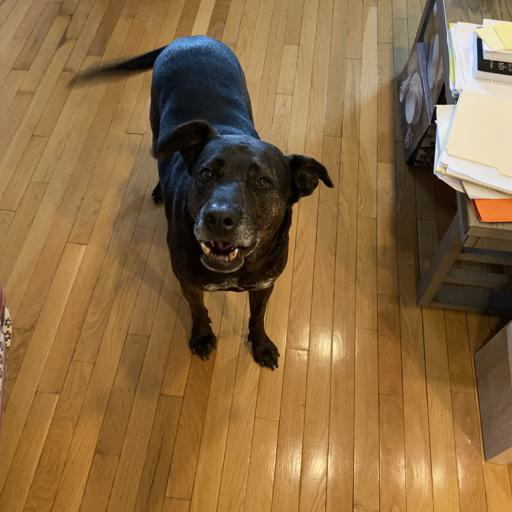

In [8]:
im

In [9]:
height = 512
width = 512
batch_size = 1

### Convert Image to Latent

In [10]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [11]:
preprocess = Compose([
    Resize((512,512)), #Resize to match VAE input size
    ToTensor(),        #Convert to tensor
    # Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))    # Normalize img tensor to range [-1,1]
])

In [12]:
im_tensor = preprocess(im).unsqueeze(0).to("cuda").half()

In [13]:
im_tensor.shape

torch.Size([1, 3, 512, 512])

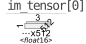

In [14]:
with tsensor.explain():
    im_tensor[0]

In [15]:
with torch.no_grad():
    im_latent = vae.encode(im_tensor)

In [16]:
im_latent.latent_dist.sample()

tensor([[[[ 5.43,  7.88,  6.65,  ...,  0.43,  7.41,  3.24],
          [ 7.69,  4.64,  7.40,  ...,  7.32,  6.82,  8.25],
          [ 7.84,  7.54,  8.35,  ..., 15.63, 13.70,  3.99],
          ...,
          [ 6.84,  5.52,  6.15,  ..., 11.13,  8.05,  7.26],
          [ 7.46,  5.49,  7.34,  ...,  7.71,  9.20,  9.74],
          [ 5.40,  7.17,  7.77,  ...,  9.09, 10.39, 10.38]],

         [[ 3.59,  4.64,  4.43,  ...,  5.70, -0.49,  6.63],
          [ 6.71, -0.16,  8.50,  ...,  4.51,  5.77,  1.60],
          [ 3.16,  5.39,  4.66,  ...,  0.36,  2.75,  6.65],
          ...,
          [ 0.20,  4.97,  6.63,  ...,  4.54,  4.02,  6.62],
          [ 4.18,  1.46,  7.37,  ...,  5.68,  8.18,  6.46],
          [ 1.03,  5.32,  5.21,  ...,  7.44,  5.01,  8.91]],

         [[-5.69,  2.02, -2.77,  ..., -1.64,  0.63, -4.86],
          [-1.72, -2.45, -1.34,  ...,  5.70,  5.56,  3.79],
          [ 2.01, -3.23,  1.42,  ..., -1.58,  0.32, -1.24],
          ...,
          [-4.19,  1.04,  1.69,  ..., -4.72, -3.21,

In [17]:
im_latent.latent_dist.sample().shape

torch.Size([1, 4, 64, 64])

In [18]:
im_latent_sample = im_latent.latent_dist.sample()

In [19]:
with torch.no_grad():
    image = vae.decode(im_latent_sample).sample

In [20]:
def latent_to_PIL(image):
    image = image.clamp(0,1)
    image = image[0].detach().cpu().permute(1,2,0).numpy()
    image = (image * 255).round().astype("uint8")
    return PIL.Image.fromarray(image)

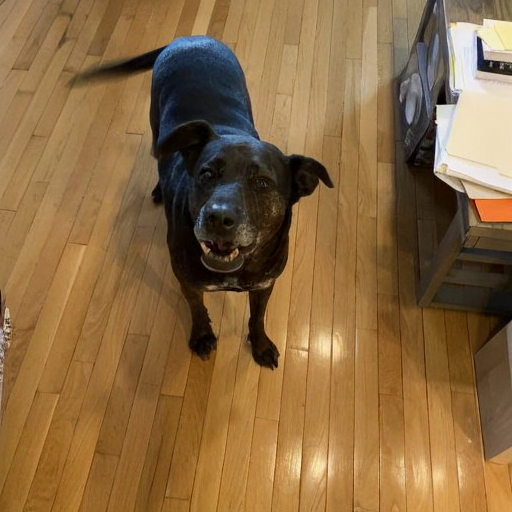

In [21]:
latent_to_PIL(image)

In [22]:
?img_convert

Object `img_convert` not found.


### Create Noise

In [23]:
unet.in_channels

4

In [24]:
latents = (torch.randn(batch_size, unet.in_channels, height // 8, width // 8) * .5).to("cuda").half()

***

In [25]:
full_noise = torch.randn(3, 512, 512).to("cuda").half()
half_noise = (full_noise * .5)

In [26]:
full_image = preprocess(im).to("cuda").half()

In [27]:
noised_image = (full_image + half_noise / 2)

In [28]:
np_noised_image = (noised_image.cpu().detach().permute(1,2,0).numpy() * 255).round().astype("uint8")

In [29]:
np_noised_image.shape

(512, 512, 3)

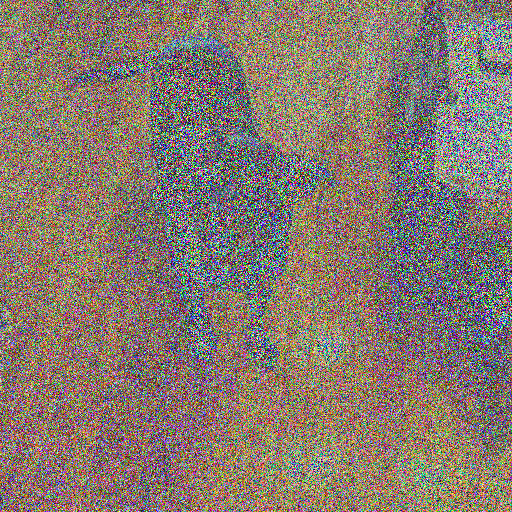

In [30]:
PIL.Image.fromarray(np_noised_image)

In [31]:
noised_latent = (im_latent.latent_dist.sample() + latents / 2)

In [32]:
im_latent

AutoencoderKLOutput(latent_dist=<diffusers.models.vae.DiagonalGaussianDistribution object at 0x7fbf6e419ba0>)

In [33]:
im_latent.latent_dist.sample()

tensor([[[[ 5.43,  7.88,  6.65,  ...,  0.43,  7.41,  3.24],
          [ 7.69,  4.64,  7.40,  ...,  7.32,  6.82,  8.25],
          [ 7.84,  7.54,  8.35,  ..., 15.63, 13.70,  3.99],
          ...,
          [ 6.84,  5.52,  6.15,  ..., 11.13,  8.05,  7.26],
          [ 7.46,  5.49,  7.34,  ...,  7.71,  9.20,  9.74],
          [ 5.40,  7.17,  7.77,  ...,  9.09, 10.39, 10.38]],

         [[ 3.59,  4.64,  4.43,  ...,  5.70, -0.49,  6.63],
          [ 6.71, -0.16,  8.50,  ...,  4.51,  5.77,  1.60],
          [ 3.16,  5.39,  4.66,  ...,  0.36,  2.75,  6.65],
          ...,
          [ 0.20,  4.97,  6.63,  ...,  4.54,  4.02,  6.62],
          [ 4.18,  1.46,  7.37,  ...,  5.68,  8.18,  6.46],
          [ 1.03,  5.32,  5.21,  ...,  7.44,  5.01,  8.91]],

         [[-5.69,  2.02, -2.77,  ..., -1.64,  0.63, -4.86],
          [-1.72, -2.45, -1.34,  ...,  5.70,  5.56,  3.79],
          [ 2.01, -3.23,  1.42,  ..., -1.58,  0.32, -1.24],
          ...,
          [-4.19,  1.04,  1.69,  ..., -4.72, -3.21,

In [35]:
latents

tensor([[[[-0.05, -1.21, -0.03,  ...,  0.28,  1.13,  0.74],
          [ 0.27,  0.55,  0.25,  ..., -0.64, -0.62,  0.20],
          [ 0.75, -0.39,  0.17,  ..., -0.55,  0.48, -0.13],
          ...,
          [-0.17,  0.26,  0.24,  ..., -0.36,  0.21, -0.35],
          [-0.41, -0.39,  0.29,  ..., -0.07, -0.22,  1.08],
          [-0.21,  0.75, -0.03,  ..., -0.72, -0.60, -0.26]],

         [[-0.45,  0.55, -0.15,  ...,  0.05, -0.27, -0.37],
          [-0.56,  0.19, -0.50,  ...,  0.54, -0.31,  0.23],
          [-0.37,  0.42,  0.05,  ..., -0.64,  0.80,  0.81],
          ...,
          [-0.16,  0.84, -0.36,  ..., -0.15, -0.25,  0.21],
          [ 0.54, -0.09,  0.33,  ...,  0.37, -0.09,  0.23],
          [-0.38,  0.09,  0.20,  ...,  0.36,  0.46,  0.47]],

         [[ 0.87, -0.07, -0.06,  ..., -0.92, -0.61,  0.18],
          [-0.29,  0.30,  0.28,  ..., -0.15, -0.58,  0.27],
          [-0.65, -0.74, -0.89,  ..., -0.33, -0.24,  0.27],
          ...,
          [ 0.47,  0.89,  0.39,  ..., -0.00,  0.05,

In [52]:
with torch.no_grad():
    noised_image = vae.decode(noised_latent).sample

In [53]:
noised_image.shape

torch.Size([1, 3, 512, 512])

In [54]:
noised_image = noised_image.clamp(0,1)

In [55]:
noised_image = noised_image[0].detach().cpu().permute(1,2,0).numpy()

In [56]:
noised_image = (noised_image * 255).round().astype("uint8")

In [57]:
noised_image

array([[[130, 101,  72],
        [149, 124,  98],
        [141, 125,  96],
        ...,
        [112,  96,  66],
        [121, 106,  73],
        [117, 103,  70]],

       [[145, 113,  84],
        [134, 105,  79],
        [111,  84,  54],
        ...,
        [110,  94,  63],
        [116, 100,  68],
        [125, 111,  75]],

       [[154, 128,  93],
        [117,  88,  56],
        [111,  82,  49],
        ...,
        [119, 106,  72],
        [120, 105,  71],
        [123, 108,  74]],

       ...,

       [[121,  73,  15],
        [123,  78,  19],
        [125,  78,  16],
        ...,
        [218, 156,  77],
        [219, 155,  78],
        [219, 155,  76]],

       [[124,  77,  15],
        [121,  78,  15],
        [126,  79,  19],
        ...,
        [218, 155,  77],
        [220, 156,  74],
        [216, 155,  72]],

       [[120,  72,  18],
        [126,  77,  12],
        [128,  78,  19],
        ...,
        [216, 151,  76],
        [219, 154,  72],
        [209, 154,  79]]

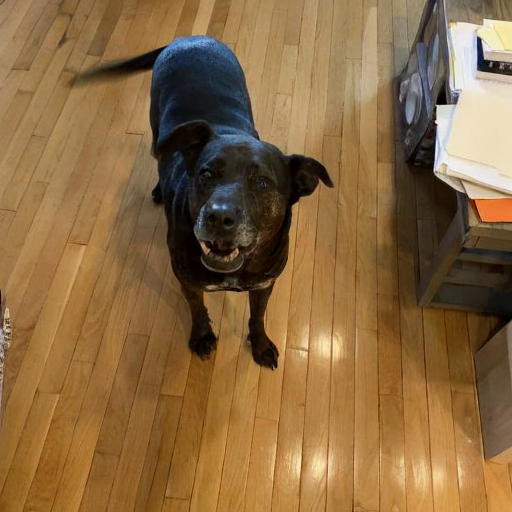

In [58]:
PIL.Image.fromarray(noised_image)

***

### Scheduling

In [ ]:
#| export
from diffusers import LMSDiscreteScheduler

In [ ]:
scheduler = LMSDiscreteScheduler(num_train_timesteps=1000, beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")

### Parameters for Generation

In [ ]:
#| export
q = ["dog"]
r = ["cat"]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

### Tokenize the text

In [ ]:
#| export
q_input = tokenizer(
    q, padding="max_length", max_length=tokenizer.model_max_length, 
    truncation=True, return_tensors="pt"
)
r_input = tokenizer(
    r, padding="max_length", max_length=tokenizer.model_max_length, 
    truncation=True, return_tensors="pt"
)

### Create Noise and Add Scheduler

In [ ]:
#| export

latents = torch.randn((batch_size, unet.in_channels, height // 8, width //8))
latents = latents.to("cuda").half()
latents.shape

In [ ]:
#| export
scheduler.set_timesteps(num_inference_steps)

In [ ]:
#| export
latents = latents * scheduler.init_noise_sigma

In [ ]:
import nbdev
nbdev.export.nb_export('diffedit.ipynb', 'app_v1')
print("export successful")